In [1]:
import torch
import torch.nn as nn
from networks import DynamicUNet, LearnableScaleDynamicUNet
from networks import dice_score

device = "cuda" if torch.cuda.is_available() else "cpu"

network = DynamicUNet(1, 2, [128, 256, 512], [128, 128, 64]).to(device)
#network = LearnableScaleDynamicUNet(1, 2, [128, 256, 512], 8, [(128, 4), (128, 2), (64, 1)]).to(device)

In [2]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import cv2 as cv
import os
import numpy as np
import re

class SegmentationDataset(Dataset):
    def __init__(self, ids, patch_folder="./segmentation/patches", mask_folder="./segmentation/masks", scale=1):
        self.ids = ids
        self.mask_folder = mask_folder
        self.patch_folder = patch_folder
        self.scale = scale
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        patch_path = os.path.join(self.patch_folder, "org_{}.bmp".format(self.ids[index]))
        mask_path = os.path.join(self.mask_folder, "mask_{}.bmp".format(self.ids[index]))

        patch = cv.imread(patch_path, cv.IMREAD_GRAYSCALE)/255.0
        #patch = np.expand_dims(patch, 0)
        patch = np.expand_dims(cv.resize(patch, None, fx=self.scale, fy=self.scale), 0)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask = cv.resize(mask, None, fx=self.scale, fy=self.scale, interpolation=cv.INTER_NEAREST)

        return torch.tensor(patch, dtype=torch.float), torch.tensor(mask, dtype=torch.long)

ids = [ re.findall("[0-9]+", name)[0] for name in os.listdir("./segmentation/patches") ]

train, test = train_test_split(ids, test_size=40)

In [4]:
learning_rate = 1e-4
batch_size = 10

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction="sum")

plateau_window = 5  # Detect plateau if training doesn't progress after num epochs
# plateau_lambda = 0.01 # Detect plateau if difference between current and best is less than lambda

scales = [1/8, 1/4, 1/2, 1]

losses = [ [] for _ in scales ]
dice_scores = [ [] for _ in scales ]

for i, scale in enumerate(scales):
    breakthrough = 999
    since = 0
    side = 128 * scale

    train_dataset = SegmentationDataset(train, scale=scale)
    test_dataset = SegmentationDataset(test, scale=scale)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    while since != plateau_window:
        # Training
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            x_hat = network(X)
            loss = train_loss_fn(x_hat, y)
            loss.backward()
            optimizer.step()

        # Testing
        with torch.no_grad():
            loss = 0
            dice_score_ = 0
            for X, y in test_loader:
                X, y = X.to(device,), y.to(device)
                x_hat = network(X)
                loss += test_loss_fn(x_hat, y).item()
                dice_score_ += dice_score(x_hat.cpu(), y.cpu(), reduction="sum")
            loss = loss / (len(test_dataset) * side * side ) 
            dice_score_ = dice_score_ / len(test_dataset)
            dice_scores[i].append(dice_score_)
            since += 1
            if loss < breakthrough:
                breakthrough = loss
                since=0
            print("Loss:", loss, "Dice score:", dice_score_)
            losses[i].append(loss)
    print("Epoch ended")
    network.use_higher_layer()

Loss: 0.2506433963775635 Dice score: 0.8265681982040405
Loss: 0.21592425107955932 Dice score: 0.8406698703765869
Loss: 0.20320012867450715 Dice score: 0.8461280107498169
Loss: 0.19989177882671355 Dice score: 0.8484419584274292
Loss: 0.1948125034570694 Dice score: 0.8507272481918335
Loss: 0.18971445858478547 Dice score: 0.8502421855926514
Loss: 0.19673066437244416 Dice score: 0.8513953924179077
Loss: 0.1917656511068344 Dice score: 0.8494061708450318
Loss: 0.1919829159975052 Dice score: 0.8518066167831421
Loss: 0.1937926858663559 Dice score: 0.8497689485549926
Loss: 0.19414761364459993 Dice score: 0.8506247282028199
Epoch ended
Loss: 0.31433854103088377 Dice score: 0.795859944820404
Loss: 0.23992905020713806 Dice score: 0.8645509719848633
Loss: 0.2090021401643753 Dice score: 0.8731854200363159
Loss: 0.18959086537361144 Dice score: 0.8847963809967041
Loss: 0.17605367302894592 Dice score: 0.8932626724243165
Loss: 0.16547061800956725 Dice score: 0.8981926441192627
Loss: 0.15607301890850067 

KeyboardInterrupt: 

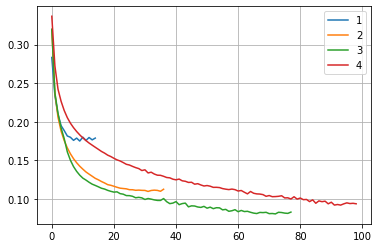

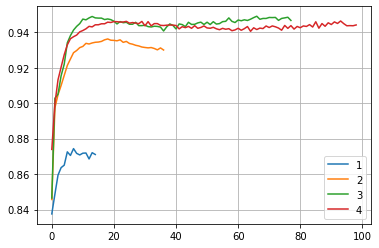

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
for loss in losses:
    plt.plot(loss)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

plt.figure()
for dice in dice_scores:
    plt.plot(dice)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

In [ ]:
dice_scores[2]

In [ ]:
from torchviz import make_dot

val = network(torch.randn((1, 1, 128, 128)).cuda()).cpu()

make_dot(val.sum(), params=dict(list(network.named_parameters()))).render("torchviz3", format="png")

In [ ]:

# temp_ = network.additional_mapper_classifiers[-2]["mapper"](torch.randn((5, 1, 128, 128)))

# add_down_ = network.additional_downscale[-2](temp_)
# downscaled_ = network.downscale(add_down_)

# #-----------------------------------#

# # temp = network.additional_mapper_classifiers[-1]["mapper"](torch.randn((5, 1, 64, 64)))

# add_down = network.additional_downscale[-1](downscaled_)
# downscaled = network.downscale(add_down)

# y_hat = network.base_unet(downscaled)

# upscaled = network.additional_upscale[-1]["upsample_conv"](y_hat)

# sth = torch.cat([upscaled, add_down], dim=1)

# res = network.additional_upscale[-1]["conv_cell"](sth)

# # res = network.additional_mapper_classifiers[-1]["classifier"](res)

# #-----------------------------------#

# upscaled = network.additional_upscale[-2]["upsample_conv"](res)

# sth = torch.cat([upscaled, add_down_], dim=1)

# res = network.additional_upscale[-2]["conv_cell"](sth)

# res = network.additional_mapper_classifiers[-2]["classifier"](res)


In [ ]:
import torch
from networks import dice_score

tab1 = torch.randn((10, 2, 64, 64))
tab2 = torch.randn((10, 64, 64)) > 0

dice_score(tab1, tab2)

tensor(0.4989)

In [ ]:
len(network.additional_mapper_classifiers)

In [ ]:
while(network.use_higher_layer() != True):
    pass